# **PROYECTO HUMOR** Modelo Binario con Modelo Preentrenado basado en BERT

**Autores:**

* Juan Camilo Acosta Rojas - 202324893
* Samuel Goncalves Vergara - 202122595
* Jefferson Hernández - 202120242
* Juan Andrés Mendez - 201815808

In [1]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 56.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 KB 109.6 MB/s eta 0:00:00


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 67.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 KB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 KB 89.8 MB/s eta 0:00:00


In [5]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.1 MB/s eta 0:00:0000:0100:01


## Importación de librerías

En este caso vamos a usar Pytorch para facilidad de entrenamiento dentro de la máquina virtual de Nvidia

In [24]:
import pandas as pd
from transformers import AutoModel, BertTokenizerFast, TFBertModel, AutoTokenizer, BertTokenizer, AdamW
#from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input,Concatenate
import tensorflow as tf
#import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
from sklearn.cluster import KMeans
import joblib
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from sklearn.metrics import classification_report

%matplotlib inline

## Carga de datos

Para este caso, vamos a emplear dos datasets y unirlos. Uno que contiene el contenido humorístico clasificado en la anterior entrega del proyecto, y el otro contenednos registros negativos, es decir, que están clasificados como que no contienen contenido humorístico.

In [6]:
url_graceful_dataset = 'humor_dataset.csv'
url_non_graceful_dataset = 'datosNochistosos.csv'

df_graceful = pd.read_csv(url_graceful_dataset)
df_non_graceful = pd.read_csv(url_non_graceful_dataset)

In [7]:
df_graceful.columns

Index(['id', 'text', 'Fuente', 'es_gracioso_p1', 'es_gracioso_p2',
       'es_gracioso_p3', 'Es_gracioso', 'nivel_gracia_p1', 'nivel_gracia_p2',
       'nivel_gracia_p3'],
      dtype='object')

In [8]:
df_non_graceful

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
0,tweet4,No se porqué me hago la cabeza deooos,0,3,0,0,0,0,0,NaN,NaN,NaN
1,tweet5,Quisiera saber que hago durante la siesta de l...,0,4,0,1,0,0,0,NaN,NaN,NaN
2,tweet6,La persona que te dice que no se arrepiente de...,0,3,1,1,0,0,0,NaN,NaN,NaN
3,tweet8,Meeee aburro,0,3,0,0,0,0,0,NaN,NaN,NaN
4,tweet9,Macri le dijo las gordas que usar calzas está ...,0,3,0,0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,tweet15086,Pobres de los que crearon el HT #Apestasaindíg...,0,3,0,0,0,0,0,NaN,NaN,NaN
9996,tweet15087,amo a bangtan,0,3,0,0,0,0,0,NaN,NaN,NaN
9997,tweet15089,Vuela conmigo ven te invito a saborear la gloria,0,3,0,0,0,0,0,NaN,NaN,NaN
9998,tweet15090,@IrxngirI Son Juanito y Maria Clara.,0,3,0,0,0,0,0,NaN,NaN,NaN


### Uniendo los datasets

In [9]:
binary_dataset= pd.concat([df_graceful, df_non_graceful])
binary_dataset

,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
0,1,"Mi abuelo vino a América buscando la libertad,...",Dataset_existente,1.0,1.0,1.0,1.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,BARRA LIBRE en mi casa hoy a partir de las 10 ...,Dataset_existente,1.0,1.0,1.0,1.0,2.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Va un pollito con un cubito Maggi bajo el braz...,Dataset_existente,1.0,1.0,1.0,1.0,4.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"-¿Ya fuiste al Laberinto? -No, está bueno? -Si...",Dataset_existente,1.0,1.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,En la calle me siento un objeto sexual\n\nMe g...,Dataset_existente,1.0,0.0,1.0,1.0,4.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,tweet15086,Pobres de los que crearon el HT #Apestasaindíg...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
9996,tweet15087,amo a bangtan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
9997,tweet15089,Vuela conmigo ven te invito a saborear la gloria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
9998,tweet15090,@IrxngirI Son Juanito y Maria Clara.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


## Preprocesamiento de datos
Para este caso, dado a que tenemos contenido de diferentes redes sociales como X. Se procede a cambiar contenido como urls y nombres de usuario etiquetados en los diferentes tweets. Además de ello, se opta por elimnar algunos caracteres especiales provenientes de emojis y otras reacciones. Además, dado que el cntenido del tweet contiene nombres de agunos archivos o iágenes que se presentant, también se considera un token especial para cada una de estas expresiones regulares presentes en el corpus.

In [10]:
def preprocess_text(text):
    # Reemplazar URLs
    text = re.sub(r'http\S+', '<URL>', text)

    # Reemplazar menciones de usuario
    text = re.sub(r'@\w+', '<USUARIO>', text)

    # Eliminar emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text)
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-\(|:-\*|:-\)|:P|:D|:<|:-P', '<EMOJI>', text)

    # Reemplazar hashtags
    text = re.sub(r'#\w+', '<HASH_TAG>', text)

   
    # Reemplazar el nombre del archivo con el token <IMAGE>
    result = re.sub(r"[\w-]+\.(jpg|jpeg|png|gif):", "<IMAGE>:", text)

    return text


Dado a que el dataset que contiene los registros no graciosos no está etiquetado como el primero, se llena con los datos con el fin de determinar en la característica a clasificar si es de contenido gracioso o no.

In [11]:
binary_dataset['Es_gracioso'] = binary_dataset['Es_gracioso'].fillna(0)
binary_dataset['text'] = binary_dataset['text'].apply(preprocess_text)
binary_dataset.head()

,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
0,1,"Mi abuelo vino a América buscando la libertad,...",Dataset_existente,1.0,1.0,1.0,1.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,BARRA LIBRE en mi casa hoy a partir de las 10 ...,Dataset_existente,1.0,1.0,1.0,1.0,2.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Va un pollito con un cubito Maggi bajo el braz...,Dataset_existente,1.0,1.0,1.0,1.0,4.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"-¿Ya fuiste al Laberinto? -No, está bueno? -Si...",Dataset_existente,1.0,1.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,En la calle me siento un objeto sexual\n\nMe g...,Dataset_existente,1.0,0.0,1.0,1.0,4.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### División de datos

En este caso, se usa una división inicial del 70% para datos de entrenamiento y 30% como conjunto de datos de prueba. Adiciónalmente, se obtiene la mitad de los datos de prueba con el fin de generar un conjunto de validación a utilizar en la etapa de entrenamiento.

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    binary_dataset['text'],
    binary_dataset['Es_gracioso'],
    random_state=2024,
    test_size=0.3,
    stratify=binary_dataset['Es_gracioso']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    random_state=2024,
    test_size=0.5,
    stratify=y_temp
)

## Tokenización del corpus
En este caso, se va a emplear un modelo basado en BERT que fue entrenado con contenido en español, facilitando la selección del vocabulario con. su tokenizador. Como primer paso, se establece la longitud de la cadena a utilizar revisando la istribución de los ejemplos de acuerdo a la longitud de caracteres.


Url del modelo: https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased

Text(0, 0.5, 'Number of texts')

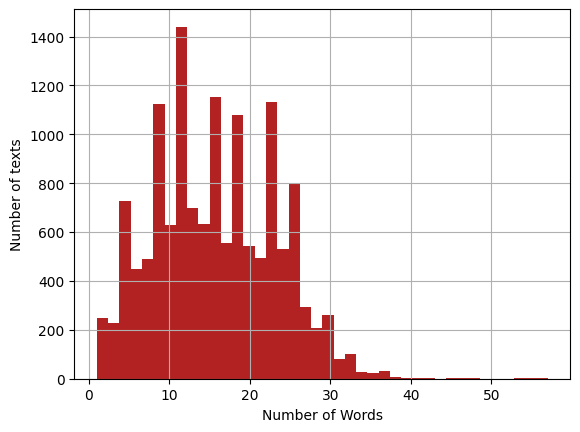

In [13]:
seq_len = [len(title.split()) for title in X_train]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

Se observa que la mayoría de registros contienen ya sea 25 tokens o menos, por lo que se establece esta cantidad como MAX_LENGTH para el tokenizador del modelo.

In [14]:
MAX_LENGHT = 25

In [15]:
tokenizer = BertTokenizerFast.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def tokenize(data_to_tokenize):
  return tokenizer.batch_encode_plus(
    data_to_tokenize.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
  )

Se procede a tokenizar cada uno de los datos en el conjunto de entranmiento, pruea y validación.

In [16]:
tokens_train = tokenize(X_train) # tokenización conjunto de entrenamiento
tokens_val = tokenize(X_val) # tokenización conjunto de validación
tokens_test = tokenize(X_test) # tokenización conjunto de test

/home/estudiante/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Se procede a insertar cada una de las secuencias en tensores para facilidad de tratamiento de datos en el modelo.

In [17]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [20]:
batch_size = 32 # tamaño del batch de entrenamiento
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

## Build Model

En este caso se carga el Modelo, adicionalmente hacemos el proceso inicial de finetuning que consiste en congelar algunos par´metros con el fin de que no pierda todas las características que había aprendido anteriormente.

In [26]:
bert_spanish = AutoModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Congelando los parámetros de entrenamiento del modelo
for param in bert_spanish.parameters():
    param.requires_grad = False

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Adicionalmente creamos unas clases que, adicionales al modelo, tendrá tanto la capa Feed Forward y su respectiva función de activación. Se opta por utilizar una capa de Dropout del 10% para evitar overfitting y usar la función de activación ReLu debido a la naturaleza discriminatoria del modelo. A continuación se resume el diseño del modelo:

- BERT: modelo preentrenado BERT
- Dropout: capa de Dropout del 10% en las capas densas
- Capa Densa: con 768 unidades para encontrar relaciones entre los datos mediante la función de activacion ReLu
- Capa Densa: de 1 unidad con el fin de discriminar si el registro es de contenido humorístico o no.

In [4]:
'''Clase BERT_model
    definición del modelo preentrenado basado en el modelo BERT
    cuenta con dos capas adicionales FeedForward de 768 y 512 o función de activación ReLu
    y una capa para discriminar si es conteido humorístico o no
'''


class BERT_model(nn.Module):
    def __init__(self, bert):
      super(BERT_model, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # capa de DroPout del 10%
      self.relu =  nn.ReLU()                    # función de activación ReLu
      self.fc1 = nn.Linear(768,512)             # capa densa 1
      self.fc2 = nn.Linear(512,2)               # capa densa 2
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

In [27]:
model = BERT_model(bert_spanish)

optimizer = AdamW(model.parameters(), lr = 1e-5)
cross_entropy  = nn.NLLLoss()
epochs = 20

/home/estudiante/venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Entrenamiento del Modelo

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch

    # Convert labels to LongTensor before calculating loss
    labels = labels.type(torch.LongTensor).to(device)  # Assuming device is defined


    model.zero_grad()                                           # Clear previously calculated gradients
    preds = model(sent_id, mask)                                # Get model predictions for current batch
    # Move predictions to the same device as labels before calculating loss
    preds = preds.to(device)  
    loss = cross_entropy(preds, labels)                         # Compute loss between actual & predicted values
    total_loss = total_loss + loss.item()
    loss.backward()                                             # Backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # Clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # Update parameters
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)
  return avg_loss

In [28]:
def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    batch = [t for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      # Convert labels to LongTensor before calculating loss
      labels = labels.type(torch.LongTensor).to(device) # Move labels to the same device as preds
      preds = preds.to(device) # Move predictions to the same device as labels
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

In [29]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Batch    50  of    438.
  Batch   100  of    438.
  Batch   150  of    438.
  Batch   200  of    438.
  Batch   250  of    438.
  Batch   300  of    438.
  Batch   350  of    438.
  Batch   400  of    438.

Evaluating...
  Batch    50  of     94.

Training Loss: 0.637
Validation Loss: 0.575

 Epoch 2 / 20
  Batch    50  of    438.
  Batch   100  of    438.
  Batch   150  of    438.
  Batch   200  of    438.
  Batch   250  of    438.
  Batch   300  of    438.
  Batch   350  of    438.
  Batch   400  of    438.

Evaluating...
  Batch    50  of     94.

Training Loss: 0.548
Validation Loss: 0.494

 Epoch 3 / 20
  Batch    50  of    438.
  Batch   100  of    438.
  Batch   150  of    438.
  Batch   200  of    438.
  Batch   250  of    438.
  Batch   300  of    438.
  Batch   350  of    438.
  Batch   400  of    438.

Evaluating...
  Batch    50  of     94.

Training Loss: 0.494
Validation Loss: 0.451

 Epoch 4 / 20
  Batch    50  of    438.
  Batch   100  of    438.
  Batch   150  of    

## Evaluación de resultados
A continuación se observa el comportamiento respecto a la pérdida de informacion conforme se va entrenando el modelo.

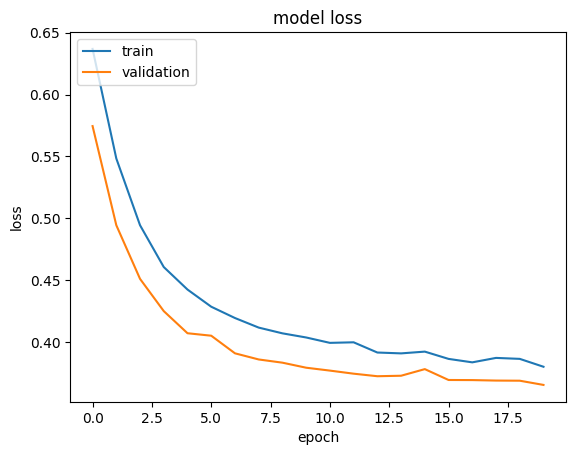

In [30]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Resultados frente al conjunto de Test

In [28]:
path = 'best_model.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83      1500
         1.0       0.81      0.86      0.84      1500

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



### Ejemplo de predicción frente a nuevos datos

In [35]:
unseen_news_text = "Dr mis tetas estan muy duras, tóque. El toca y ella le pregunta:-Es grave? -No pero es contagioso Mire como se me puso de duro el pipi Toque."
unseen_news_text = preprocess_text(unseen_news_text)

tokens_unseen = tokenizer.batch_encode_plus(
    [unseen_news_text],
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
result = preds[0]

if result == 0:
    print("Doesn't have humor content")
  
else:
    print("Has humor content")

Has humor content


### Guardando el Modelo

In [33]:
torch.save(model, 'model_humor.pt')

Matriz de confusión:
 [[1208  292]
 [ 212 1288]]


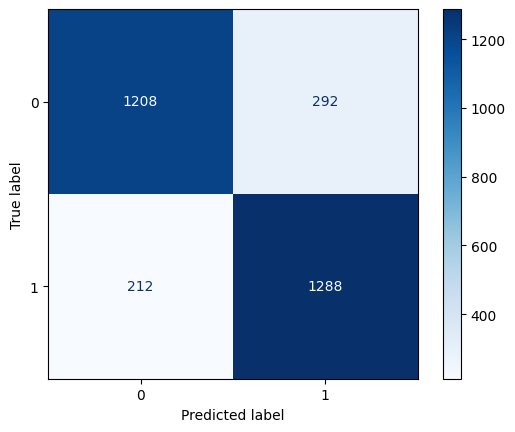

In [25]:
# Cargar el modelo
model_path = "model_humor.pt"  # Ruta al modelo guardado
model = torch.load(model_path)  # O usa `torch.load()` y carga manualmente el estado si usaste state_dict
model.eval()  # Cambiar a modo de evaluación

# Preparar el conjunto de prueba
test_loader = ...  # DataLoader para el conjunto de prueba
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Variables para almacenar predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

# Evaluar en el conjunto de prueba
with torch.no_grad():
    for batch in test_dataloader:
        # Desempaquetar el batch
        inputs, masks, labels = batch
        
        # Enviar a GPU si está disponible
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        # Obtener predicciones del modelo
        outputs = model(inputs, masks)
        _, preds = torch.max(outputs, 1)  # Obtener la clase predicha
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:\n", cm)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()